# Installation and Imports

In [12]:
!pip install einops

In [13]:
import torch
import torchvision
import numpy as np
import einops as eo
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

# Part 0: Utils

In [14]:
import numpy as np

from PIL.Image import fromarray
from IPython import get_ipython


def display_np_arrays_as_images():
    def np_to_png(a):
        if 2 <= len(a.shape) <= 3:
            return fromarray(np.array(np.clip(a, 0, 1) * 255, dtype='uint8'))._repr_png_()
        else:
            return fromarray(np.zeros([1, 1], dtype='uint8'))._repr_png_()

    def np_to_text(obj, p, cycle):
        if len(obj.shape) < 2:
            print(repr(obj))
        if 2 <= len(obj.shape) <= 3:
            pass
        else:
            print('<array of shape {}>'.format(obj.shape))

    get_ipython().display_formatter.formatters['image/png'].for_type(np.ndarray, np_to_png)
    get_ipython().display_formatter.formatters['text/plain'].for_type(np.ndarray, np_to_text)


from IPython.display import display_html

_style_inline = """<style>
.einops-answer {
    color: transparent;
    padding: 5px 15px;
    background-color: #def;
}
.einops-answer:hover { color: blue; }
</style>
"""


def guess(x):
    display_html(
        _style_inline
        + "<h4>Answer is: <span class='einops-answer'>{x}</span> (hover to see)</h4>".format(x=tuple(x)),
        raw=True)

In [15]:
display_np_arrays_as_images()

In [16]:
!wget https://github.com/arogozhnikov/einops/raw/master/docs/resources/test_images.npy

--2024-02-24 09:13:59--  https://github.com/arogozhnikov/einops/raw/master/docs/resources/test_images.npy
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/arogozhnikov/einops/master/docs/resources/test_images.npy [following]
--2024-02-24 09:14:00--  https://raw.githubusercontent.com/arogozhnikov/einops/master/docs/resources/test_images.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1327232 (1.3M) [application/octet-stream]
Saving to: ‘test_images.npy’

test_images.npy     100%[===================>]   1.27M  --.-KB/s    in 0.06s   

2024-02-24 09:14:00 (23.0 MB/s) - ‘test_images.npy’ saved [1

# Part 1: Get familiar with einpos API

## 1.1: Native code has bad readability

In [17]:
images = np.load('./test_images.npy', allow_pickle=False)
images.shape

(6, 96, 96, 3)

In [18]:
print(images[0, :, :, :].shape)
images[0, :, :, :]

(96, 96, 3)


(96, 96, 3)


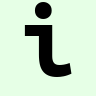

In [19]:
print(images[1, :, :, :].shape)
images[1, :, :, :]

(96, 96, 3)


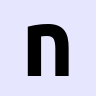

In [20]:
print(images[2, :, :, :].shape)
images[2, :, :, :]

(96, 96, 3)


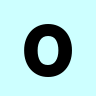

In [21]:
print(images[3, :, :, :].shape)
images[3, :, :, :]

(96, 96, 3)


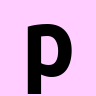

In [22]:
print(images[4, :, :, :].shape)
images[4, :, :, :]

In [23]:
print(images[5, :, :, :].shape)
images[5, :, :, :]

(96, 96, 3)


In [13]:
# We want to collapse a batch of images into a single image by placing images in a row next to each other.
# images: (6, 96, 96, 3)
# (96, 96*6, 3)

single_image = images.reshape((96, 96*6, 3))
single_image

In [14]:
# Correct way: (6, 96, 96, 3) -> (96, 6, 96, 3) -> reshape to (96, 96*6, 3)
single_image = images.transpose((1, 0, 2, 3)).reshape((96, 96*6, 3))
single_image

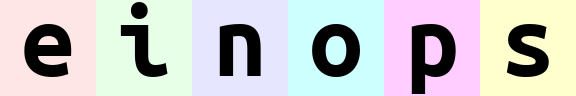

In [15]:
# Correct and clean
single_image = eo.rearrange(images, 'b h w c -> h (b w) c')
single_image

## 1.2: eo.rearrange

### 1.2.1: Composition

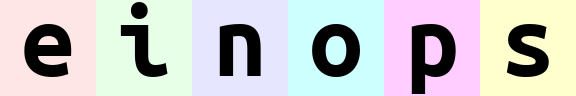

In [16]:
# all images in one row
eo.rearrange(images, 'b h w c -> h (b w) c')

In [17]:
# all images in one column
eo.rearrange(images, 'b h w c -> (b h) w c')

### 1.2.2: Decomposition

In [ ]:
# images: (6, 96, 96, 3)

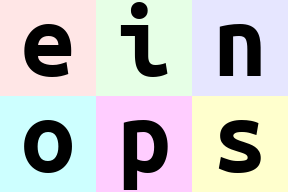

In [18]:
eo.rearrange(images, '(b1 b2) h w c -> (b1 h) (b2 w) c ', b1=2)

In [19]:
eo.rearrange(images, '(b1 b2) h w c -> (b1 h) (b2 w) c ', b1=3)

## 1.3: eo.repeat

In [20]:
images.shape

(6, 96, 96, 3)

In [21]:
images[0]

In [22]:
eo.repeat(images[0], 'h w c -> h (r w) c', r=3)

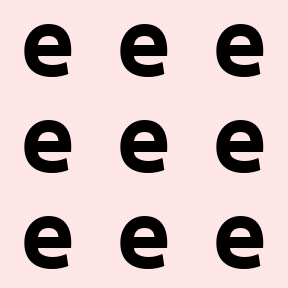

In [23]:
eo.repeat(images[0], 'h w c -> (r1 h) (r2 w) c', r1=3, r2=3)

## 1.4: eo.reduce

In [24]:
images.shape

(6, 96, 96, 3)

(96, 96, 3)


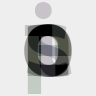

In [26]:
print(images.mean(0).shape)
images.mean(0)

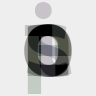

In [26]:
eo.reduce(images, 'b h w c -> h w c', 'mean')

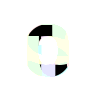

In [27]:
eo.reduce(images, 'b h w c -> h w c', 'max')

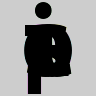

In [28]:
eo.reduce(images, 'b h w c -> h w c', 'min')

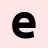

In [29]:
eo.reduce(images[0], '(h 2) (w 2) c -> h w c', 'mean')

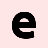

In [30]:
eo.reduce(images[0], '(h 2) (w 2) c -> h w c', 'min')

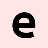

In [31]:
eo.reduce(images[0], '(h 2) (w 2) c -> h w c', 'max')

## 1.5: eo.pack and eo.unpack

In [29]:
h, w = 100, 200

image_rgb = np.random.random([h, w, 3])
image_depth = np.random.random([h, w])

print(image_rgb.shape, image_depth.shape)

(100, 200, 3) (100, 200)


In [30]:
# We want to stack these two and get (100, 200, 4)

packed, ps = eo.pack([image_rgb, image_depth], 'h w *')
packed.shape

(100, 200, 4)

pattern h w * means that

- output is 3-dimensional
- first two axes (h and w) are shared across all inputs and also shared with output
- inputs, however do not have to be 3-dimensional. They can be 2-dim, 3-dim, 4-dim, etc.
- Regardless of inputs dimensionality, they all will be packed into 3-dim output, and information about how they were packed is stored in PS


In [34]:
ps

[(3,), ()]

In [35]:
unpacked_rgb, unpacked_depth = eo.unpack(packed, ps, 'h w *')
unpacked_rgb.shape, unpacked_depth.shape

((100, 200, 3), (100, 200))

In [36]:
[r, g, b, d] = eo.unpack(packed, [[1], [1], [1], [1]], 'h w *')
r.shape, g.shape, b.shape, d.shape

((100, 200, 1), (100, 200, 1), (100, 200, 1), (100, 200, 1))

In [37]:
[r, g, b, d] = eo.unpack(packed, [[], [], [], []], 'h w *')
r.shape, g.shape, b.shape, d.shape

((100, 200), (100, 200), (100, 200), (100, 200))

In [38]:
[rg, bd] = eo.unpack(packed, [[2], [2]], 'h w *')
rg.shape, bd.shape

((100, 200, 2), (100, 200, 2))

In [32]:
[x, y] = eo.unpack(packed, [[2, 1], [2, 1]], 'h w *')
x.shape, y.shape

((100, 200, 2, 1), (100, 200, 2, 1))

- einops.pack is a 'more generic concatenation' (that can stack too)
- einops.unpack is a 'more generic split'

## 1.6: eo.einsum

In [36]:
A = torch.randn((2, 3))
B = torch.randn((3, 4))

C = eo.einsum(A, B, 'i j, j k -> i k')
C.shape

torch.Size([2, 4])

3 Rules:
- Repeating letters between input arrays means that values along those
axes will be multiplied together. The products make up the values for the output array.
- Omitting a letter from the output means that values along that axis will be summed.
- We can return the unsummed axes in any order we like.

### 1.6.1: A.T

In [37]:
A = torch.randn((2, 3))
Atranspose = eo.einsum(A, 'i j -> j i')
print(A)
print(Atranspose)

tensor([[ 1.9553, -1.0360,  0.2069],
        [-0.9417, -0.7844, -0.4836]])
tensor([[ 1.9553, -0.9417],
        [-1.0360, -0.7844],
        [ 0.2069, -0.4836]])


### 1.6.2: diag(A)

Exception case: when subscript is repeated for the same input

In [38]:
A = torch.randn((3, 3))
diagA = eo.einsum(A, 'i i -> i')
print(A)
print(diagA)

tensor([[-0.2684, -0.3795, -1.1806],
        [-0.8656,  0.8348, -0.1879],
        [-0.4259,  1.4165, -2.8727]])
tensor([-0.2684,  0.8348, -2.8727])


### 1.6.3: trace(A)

In [39]:
A = torch.randn((3, 3))
traceA = eo.einsum(A, 'i i -> ')
print(A)
print(traceA)

tensor([[-1.7653, -0.2046,  0.0667],
        [ 3.3755,  2.0883, -0.9960],
        [-1.0201, -0.3906, -2.0104]])
tensor(-1.6874)


### 1.6.4: sum(A), sum(A, dim=0), sum(A, dim=1)

In [40]:
A = torch.randn((2, 3))
sumA = eo.einsum(A, 'i j -> ')
sumA0 = eo.einsum(A, 'i j -> j')
sumA1 = eo.einsum(A, 'i j -> i')
print(A)
print(sumA)
print(sumA0)
print(sumA1)

tensor([[0.3054, 0.2894, 0.9940],
        [0.2185, 0.4604, 0.4969]])
tensor(2.7645)
tensor([0.5239, 0.7498, 1.4908])
tensor([1.5888, 1.1757])


### 1.6.5: A * B

In [41]:
A = torch.randn((2, 3))
B = torch.randn((2, 3))

# A: (2, 3)
# B: (2, 3)
# A * B: (2, 3)

C = eo.einsum(A, B, 'i j, i j -> i j')
print(A)
print(B)
print(C)

tensor([[ 1.3565, -1.2065,  1.4576],
        [-1.2799,  1.1202, -0.3468]])
tensor([[-0.4084,  1.6377,  0.0432],
        [-0.5159, -1.0260,  0.5204]])
tensor([[-0.5539, -1.9759,  0.0630],
        [ 0.6603, -1.1493, -0.1805]])


### 1.6.6: dot(A, B)

In [42]:
A = torch.randn((2, 3))
B = torch.randn((3, 4))
C = eo.einsum(A, B, 'i j, j k -> i k')
print(A)
print(B)
print(C)

tensor([[ 1.1775,  0.1660,  1.0718],
        [-0.3850,  0.5335, -0.7540]])
tensor([[ 0.0545,  0.9904,  0.9520, -2.6626],
        [ 0.4002,  0.9743,  0.8738, -0.8873],
        [ 1.4221, -1.5068, -2.2996,  0.1308]])
tensor([[ 1.6548, -0.2871, -1.1988, -3.1423],
        [-0.8798,  1.2747,  1.8337,  0.4531]])


### 1.6.7: outer(A, B)

In [43]:
A = torch.randn((3,))
B = torch.randn((2,))

# A: (3,) -> (3, 1)
# B: (2,) -> (1, 2)
# A * B: (3, 2) = C

C = eo.einsum(A, B, 'i, j -> i j')
print(A)
print(B)
print(C)

tensor([ 0.2708,  2.0480, -0.5748])
tensor([1.0207, 0.2990])
tensor([[ 0.2765,  0.0810],
        [ 2.0904,  0.6124],
        [-0.5867, -0.1719]])


# Part 2: DL Practice

## 2.1: Flattening

In [84]:
x = torch.randn([10, 3, 200, 300])
flat_x = eo.rearrange(x, 'b c h w -> b (c h w)')
x.shape, flat_x.shape

(torch.Size([10, 3, 200, 300]), torch.Size([10, 180000]))

## 2.2: Pooling

In [86]:
x = torch.randn([10, 3, 256, 256])

# max pool with kernel 2x2
xpool = eo.reduce(x, 'b c (h k1) (w k2) -> b c h w', reduction='max', k1=2, k2=2)
x.shape, xpool.shape

(torch.Size([10, 3, 256, 256]), torch.Size([10, 3, 128, 128]))

In [87]:
# avg pool with kernel 2x2
xpool = eo.reduce(x, 'b c (h k1) (w k2) -> b c h w', reduction='mean', k1=2, k2=2)
x.shape, xpool.shape

(torch.Size([10, 3, 256, 256]), torch.Size([10, 3, 128, 128]))

In [88]:
# global average pooling
xpool = eo.reduce(x, 'b c h w -> b c', reduction='mean')
x.shape, xpool.shape

(torch.Size([10, 3, 256, 256]), torch.Size([10, 3]))

## 2.3 Converting bhwc to bchw format

In [40]:
x = eo.rearrange(x, 'b h w c -> b c h w')
x.shape

torch.Size([10, 3, 200, 300])

## 2.4 Auto-batching

ML models by default accept batches: batch of images, or batch of sentences, or batch of audios, etc.

During debugging or inference, however, it is common to pass a single image instead (and thus output should be a single prediction)

Let's write a universal predictor that works with both.

In [50]:
def classifier(images_bhwc):
    predictions = eo.reduce(images_bhwc, 'b h w c -> b c', 'mean', h=100, w=200, c=3)
    return predictions

In [51]:
def universal_predict(images):
    '''
    images.shape: (h w c) or (b h w c) or (b f h w c) or (x y z h w c) or ...

    '''
    images, _ = eo.pack([images], '* h w c')
    return classifier(images)

In [52]:
h, w = 100, 200
print(universal_predict(np.zeros([h, w, 3])).shape)
batch = 5
print(universal_predict(np.zeros([batch, h, w, 3])).shape)
n_frames = 7
print(universal_predict(np.zeros([batch, n_frames, h, w, 3])).shape)

(1, 3)
(5, 3)
(35, 3)


## 2.5 Class token in ViT

In [89]:
batch, height, width, c = 6, 16, 16, 256
patch_tokens = np.random.random([batch, height, width, c])
class_tokens = np.zeros([batch, c])

print(patch_tokens.shape, class_tokens.shape)

(6, 16, 16, 256) (6, 256)


In [54]:
# Input shape: (b s c)
# Output shape: (b s c)

def transformer_mock(x_btc):
    assert len(x_btc.shape) == 3
    return x_btc

In [57]:
def vit_vanilla(class_tokens, patch_tokens):

    b, h, w, c = patch_tokens.shape
    class_tokens_b1c = class_tokens[:, np.newaxis, :]                                   # (6, 1, 256)
    patch_tokens_btc = np.reshape(patch_tokens, [b, -1, c])                             # (6, 256, 256)
    input_packed = np.concatenate([class_tokens_b1c, patch_tokens_btc], axis=1)         # (6, 257, 256)
    output_packed = transformer_mock(input_packed)                                      # (6, 257, 256)
    class_token_emb = np.squeeze(output_packed[:, :1, :], 1)                            # (6, 256)
    patch_tokens_emb = np.reshape(output_packed[:, 1:, :], [b, h, w, -1])               # (6, 16, 16, 256)
    return class_token_emb, patch_tokens_emb

class_token_emb1, patch_tokens_emb1 = vit_vanilla(class_tokens, patch_tokens)
class_token_emb1.shape, patch_tokens_emb1.shape

((6, 256), (6, 16, 16, 256))

In [90]:
def vit_einops(class_tokens, patch_tokens):
    input_packed, ps = eo.pack([class_tokens, patch_tokens], 'b * c')               # (6, 257, 256)
    print(ps)
    output_packed = transformer_mock(input_packed)
    return eo.unpack(output_packed, ps, 'b * c_out')                                # (6, 256), (6, 16, 16, 256)

class_token_emb2, patch_tokens_emb2 = vit_einops(class_tokens, patch_tokens)
class_token_emb2.shape, patch_tokens_emb2.shape

[(), (16, 16)]


((6, 256), (6, 16, 16, 256))

# Part 3: Common Architectures

## 3.1: Self-attention

In [53]:
class SelfAttention(nn.Module):

    def __init__(self, dim):
        super().__init__()

        self.q_proj = nn.Linear(dim, dim, bias=False)
        self.k_proj = nn.Linear(dim, dim, bias=False)
        self.v_proj = nn.Linear(dim, dim, bias=False)
        self.scale_factor = dim ** -0.5

    def forward(self, x):
        assert x.dim() == 3, '3D tensor must be provided (B N D)'

        # Step 1
        q = self.q_proj(x)  # [b, n, d]
        k = self.k_proj(x)  # [b, n, d]
        v = self.v_proj(x)  # [b, n, d]

        # q: (b i d)
        # k: (b j d)
        # q * k: (b i j d)
        # output: (b i j)

        scaled_dot_prod = eo.einsum(q, k, 'b i d , b j d -> b i j') * self.scale_factor          # (b, n, n)
        attention = torch.softmax(scaled_dot_prod, dim=-1)
        output = eo.einsum(attention, v, 'b i j , b j d -> b i d')

        return output

In [54]:
self_attention = SelfAttention(128)

x = torch.randn((8, 10, 128))
x_new = self_attention(x)
print(x.shape, x_new.shape)

torch.Size([8, 10, 128]) torch.Size([8, 10, 128])


## 3.2: MultiHeadSelfAttention

In [64]:
class MultiHeadSelfAttention(nn.Module):

    def __init__(self, dim, heads=4):
        super().__init__()

        head_dim = int(dim / heads)
        self.q_proj = nn.Linear(dim, dim, bias=False)
        self.k_proj = nn.Linear(dim, dim, bias=False)
        self.v_proj = nn.Linear(dim, dim, bias=False)
        self.scale_factor = dim ** -0.5
        self.heads = heads

    def forward(self, x):
        assert x.dim() == 3, '3D tensor must be provided (B N D)'

        # Step 1
        q = self.q_proj(x)  # [b, n, d]
        k = self.k_proj(x)  # [b, n, d]
        v = self.v_proj(x)  # [b, n, d]

        # hd = 32
        q = eo.rearrange(q, 'b n (h hd) -> b h n hd', h=self.heads)
        k = eo.rearrange(k, 'b n (h hd) -> b h n hd', h=self.heads)
        v = eo.rearrange(v, 'b n (h hd) -> b h n hd', h=self.heads)

        scaled_dot_prod = eo.einsum(q, k, 'b h n1 hd , b h n2 hd -> b h n1 n2') * self.scale_factor          # (b, n, n)
        attention = torch.softmax(scaled_dot_prod, dim=-1)
        output = eo.einsum(attention, v, 'b h n1 n2 , b h n2 hd -> b h n1 hd')
        output = eo.rearrange(output, 'b h n hd -> b n (h hd)')

        return output

In [65]:
mhsa = MultiHeadSelfAttention(128, 8)

x = torch.randn((8, 10, 128))
x_new = mhsa(x)
print(x.shape, x_new.shape)

torch.Size([8, 10, 128]) torch.Size([8, 10, 128])


## 3.3: Transformer Encoder

In [69]:
class TransformerEncoder(nn.Module):
    def __init__(self, dim, heads=8, dim_linear_block=64):
        super().__init__()
        self.mhsa = MultiHeadSelfAttention(dim=dim, heads=heads)
        self.norm_1 = nn.LayerNorm(dim)
        self.norm_2 = nn.LayerNorm(dim)

        self.linear = nn.Sequential(
            nn.Linear(dim, dim_linear_block),
            nn.ReLU(),
            nn.Linear(dim_linear_block, dim),
            )

    def forward(self, x):
        y = self.mhsa(x)
        y = self.norm_1(y + x)
        z = self.linear(y)
        out = self.norm_2(z) + y
        return out

In [70]:
transformer = TransformerEncoder(128, 8, 64)

x = torch.randn((8, 10, 128))
x_new = transformer(x)
print(x.shape, x_new.shape)

torch.Size([8, 10, 128]) torch.Size([8, 10, 128])
